In [9]:
import os
import glob
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
import astropy.cosmology as co

import time, datetime
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
from astropy.convolution import convolve, Box1DKernel
import palettable
%matplotlib inline
from scipy.interpolate import *


In [10]:
wvgem09, flgem09=np.loadtxt('gemini09.txt', unpack=True)



In [24]:
def linefit(inwave=wvgem09, influx=flgem09, range1=[4800, 4850], range2=[5100, 5150], linerange=[4964, 5058], d_reg=25, DoPlot=True):
    
    wavelength=inwave
    flux=influx


    allfluxval=[()]
    
    
    for i in range(0,500):
        
        #setting ranges for where continuum is featureless above and below emission line
        lowlim=range1[0]
        uplim=range1[1]
        
        lowlim2=range2[0]
        uplim2=range2[1]

        #setting range for emission line
        line1=linerange[0]
        line2=linerange[1]
        
        ##picking a random value to calculate continuum flux from
        ##let's randomly resample %d_reg angstrom size bins 
        cont_1=np.random.randint(lowlim, uplim, 1 )
        cont_2=cont_1+d_reg
        
        cont_3=np.random.randint(lowlim2, uplim2, 1)
        cont_4=cont_3+d_reg
    

        ##setting two regions to calculate the average continuum flux
        reg_1=np.where((wavelength>cont_1)&(wavelength<cont_2))
        reg_2=np.where((wavelength>cont_3)&(wavelength<cont_4))
        
        #line region
        reg_line=np.where((wavelength>line1)&(wavelength<line2))
        
        #continuum flux before and after emission line
        cont2=np.average(flux[reg_2])
        cont1=np.average(flux[reg_1])
       
    
        ##fitting a straight line to the region with line emission
        x1=line1
        x2=line2
        y1=cont1
        y2=cont2
        m = (y2-y1)/(x2-x1)
        b=y2-(m*x2)
        xnew=wavelength[reg_line]
        ynew=m*xnew+b
        
        
        ##setting the plot ylimits
        pltlowlim=np.min(flux)-20
        plthiglim=np.max(flux[reg_line])+20
        
 
        if DoPlot:
            ##!!only make one plot!!
            if np.size(allfluxval)<1:

                plt.figure(figsize=(10,8))
                plt.plot(wavelength, flux, '--', lw=2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[6], zorder=10)
                
                ##plotting all the various regions
                plt.axvline(x=line1, color=palettable.cubehelix.cubehelix3_16.mpl_colors[10], lw=2)
                plt.axvline(x=line2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[10], lw=2)
    

                plt.axvline(x=cont_1, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], lw=2)
                plt.axvline(x=cont_2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], lw=2)
                plt.axvspan(cont_3, cont_4, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], alpha=0.25)
                plt.axvline(x=cont_3, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], lw=2)
                plt.axvline(x=cont_4, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], lw=2)
                plt.axvspan(cont_1, cont_2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[8], alpha=0.25)
                plt.axvspan(line1, line2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[10], alpha=0.25)
                
                
                plt.axvspan(lowlim, uplim+25, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5], alpha=0.15)

                plt.axvspan(lowlim2, uplim2+25, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5], alpha=0.15)

                plt.plot(xnew, ynew,  color=palettable.cubehelix.cubehelix3_16.mpl_colors[3], zorder=20, lw=4 )
                plt.axvline(x=lowlim, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5], linestyle='--', lw=2)
                plt.axvline(x=uplim+d_reg, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5], linestyle='--', lw=2)
                plt.axvline(x=uplim2+d_reg, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5],linestyle='--', lw=2)
                plt.axvline(x=lowlim2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[5], linestyle='--', lw=2)
                plt.axhline(y=cont1, color=palettable.cubehelix.cubehelix3_16.mpl_colors[12], lw=2)
                plt.axhline(y=cont2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[12], lw=2)
                plt.axhspan(cont1, cont2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[12], alpha=0.25)
                
                plt.xlim(4700, 5300)
                plt.ylim(pltlowlim, plthiglim)
                plt.savefig('cont_line.png')

        ##calculating equivalent width
        d_lambda= wavelength[1]-wavelength[0]
        eq_wid=np.sum(1-(flux[reg_line]/ynew))*d_lambda
        
        ##gathering up all the trials together
        if np.size(allfluxval)<1:
            allfluxval=eq_wid
        else:
            allfluxval=np.hstack((allfluxval, eq_wid))
            
    
  
    ##taking average and standard deviation
    avg=np.average(allfluxval)
    std=np.std(allfluxval)
    
    
    
    return avg, std

-34.3697646542 1.03398222594


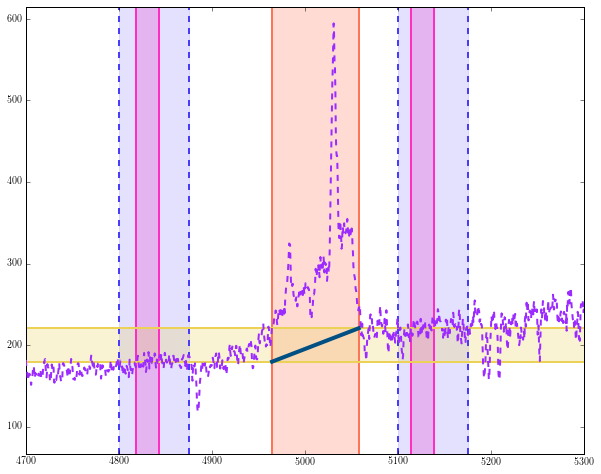

In [25]:
eq_wid, err=linefit()

#multiplying by 3/4 because this example is [OIII] with a 3:1 ratio, and we only want equivalent width in the 5007 region.

print 0.75*eq_wid, 0.75*err